In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import esmlab
import utils
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

## First do nutrients

In [2]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/month_1'
variables = ['NO3','SiO3','PO4']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT']
path

'/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/month_1'

### get monthly data and immediately convert it to annual

In [3]:
def preprocess(ds):
    ds=ds.isel(z_t=0)
    #ds=ds.isel(z_t_150m=0)
    return ds

In [4]:
%%time

ds_ann = xr.Dataset()

#for year in np.arange(1997,2006,1):
for year in np.arange(1997,2018,1):
    yr4="{:04d}".format(year)
    ds = xr.Dataset()
    print(year)
    for v in variables:  
        print(v)
        files = sorted(glob(f'{path}/{case}.pop.h.{v}.{yr4}01-{yr4}12.nc'))
        
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

        ds = xr.merge((ds, dsv))

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    ds = ds.mean(dim='time')
    
    ## add it to the annual file
    ds_ann = xr.concat([ds_ann, ds], "time")

1997
NO3
SiO3
PO4
1998
NO3
SiO3
PO4
1999
NO3
SiO3
PO4
2000
NO3
SiO3
PO4
2001
NO3
SiO3
PO4
2002
NO3
SiO3
PO4
2003
NO3
SiO3
PO4
2004
NO3
SiO3
PO4
2005
NO3
SiO3
PO4
2006
NO3
SiO3
PO4
2007
NO3
SiO3
PO4
2008
NO3
SiO3
PO4
2009
NO3
SiO3
PO4
2010
NO3
SiO3
PO4
2011
NO3
SiO3
PO4
2012
NO3
SiO3
PO4
2013
NO3
SiO3
PO4
2014
NO3
SiO3
PO4
2015
NO3
SiO3
PO4
2016
NO3
SiO3
PO4
2017
NO3
SiO3
PO4
CPU times: user 9min 40s, sys: 1min 3s, total: 10min 43s
Wall time: 12min 10s


In [5]:
ds_ann

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 21)
Coordinates:
    TLAT     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLONG    (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nlat, nlon, time
Data variables:
    NO3      (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    PO4      (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    dz       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    SiO3     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    KMT      (time, nlat, nlon) float64 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

### spin up some dask to make the processing faster

In [20]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='25GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [21]:
cluster, client = get_ClusterClient()
cluster.scale(20) 

In [22]:
client

Client Scheduler: tcp://128.117.208.86:35287 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/43039/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')

area = ds_grid.TAREA
lats = ds_grid.TLAT
lons = ds_grid.TLONG

In [4]:
rmse_global = xr.Dataset()

### Make a mean over time

In [6]:
ds = ds_ann.mean(dim='time')

In [11]:
#ds = ds.compute()

In [12]:
ds

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600)
Coordinates:
    TLAT     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLONG    (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nlat, nlon
Data variables:
    NO3      (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    PO4      (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    dz       float32 dask.array<chunksize=(), meta=np.ndarray>
    SiO3     (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT      (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>

### Get WOA data

In [12]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_x0.1POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [13]:
ds_woa = ds_woa.isel(z_t=0)

In [14]:
#ds_woa['z_t'] = ds.z_t

NO3_diff = ds.NO3 - ds_woa.NO3
PO4_diff = ds.PO4 - ds_woa.PO4
SiO3_diff = ds.SiO3 - ds_woa.SiO3

### Calculate RMSE for surface nuts

In [16]:
rmse_global['NO3']=esmlab.statistics.weighted_rmsd(ds.NO3, ds_woa.NO3, dim=['nlat', 'nlon'], weights=area)
rmse_global['PO4']=esmlab.statistics.weighted_rmsd(ds.PO4, ds_woa.PO4, dim=['nlat', 'nlon'], weights=area)
rmse_global['SiO3']=esmlab.statistics.weighted_rmsd(ds.SiO3, ds_woa.SiO3, dim=['nlat', 'nlon'], weights=area)

In [17]:
rmse_global['NO3'].values

array(2.34632579)

In [18]:
rmse_global['PO4'].values

array(0.18605326)

In [19]:
rmse_global['SiO3'].values

array(6.31096642)

In [20]:
esmlab.statistics.weighted_corr

<function esmlab.statistics.weighted_corr(x, y, dim=None, weights=None, return_p=True)>

### Calculate spatial correlation

In [21]:
no3_spat_corr=esmlab.statistics.weighted_corr(ds.NO3, ds_woa.NO3, dim=['nlat', 'nlon'], weights=area)
po4_spat_corr=esmlab.statistics.weighted_corr(ds.PO4, ds_woa.PO4, dim=['nlat', 'nlon'], weights=area)
sio3_spat_corr=esmlab.statistics.weighted_corr(ds.SiO3, ds_woa.SiO3, dim=['nlat', 'nlon'], weights=area)


In [22]:
no3_spat_corr.r.values

array(0.9644565)

In [23]:
no3_spat_corr.p.values

array(0.)

In [24]:
po4_spat_corr.r.values

array(0.95323229)

In [25]:
po4_spat_corr.p.values

array(0.)

In [26]:
sio3_spat_corr.r.values

array(0.91999681)

In [27]:
sio3_spat_corr.p.values

array(0.)

## Do COPEPOD

In [3]:
ds_copepod = xr.open_zarr('/glade/u/home/kristenk/Nuts2Fish/preprocessing/regrid/data/POP_tx0.1v3/copepod-2012__cmass-m00-qtr.zarr')

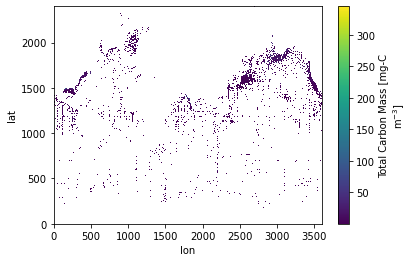

In [4]:
ds_copepod.copepod_C.plot()

In [5]:
ds_chl_obs = xr.open_dataset('/glade/work/kristenk/satellite_data/globcolour_chl/POP_grid_x01_mean/POP_tx0.1v3/mean_glob_colour_chl.nc')

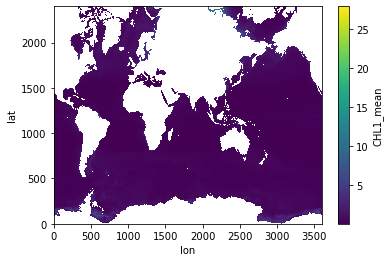

In [8]:
ds_chl_obs.CHL1_mean.plot()

In [6]:
ds_chl_cesm = xr.open_dataset('/glade/derecho/scratch/kristenk/hi-res-proc/FOSI-HR-surface_chl_1998-2005mean.nc')
ds_mesozoo_cesm = xr.open_dataset('/glade/derecho/scratch/kristenk/hi-res-proc/FOSI-HR-mesozooC_1998-2005mean.nc')

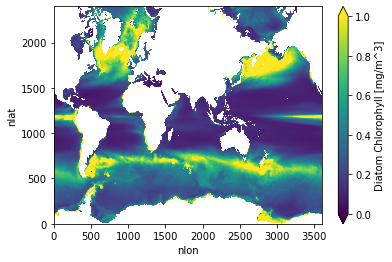

In [11]:
ds_chl_cesm.Chl_surf.plot(vmin=0,vmax=1)

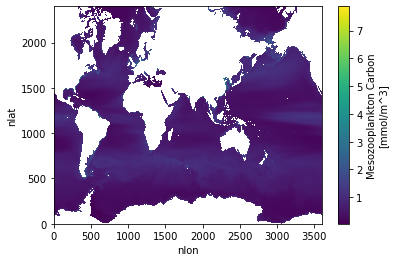

In [13]:
ds_mesozoo_cesm.mesozooC.plot()

In [20]:
ds_chl_cesm.nlon

<xarray.DataArray 'nlon' (nlon: 3600)>
array([   0,    1,    2, ..., 3597, 3598, 3599])
Dimensions without coordinates: nlon

In [29]:
ds_copepod = ds_copepod.rename({'lon':'nlon'})
ds_copepod = ds_copepod.rename({'lat':'nlat'})

In [23]:
ds_chl_obs = ds_chl_obs.rename({'lon':'nlon'})

In [24]:
ds_chl_obs = ds_chl_obs.rename({'lat':'nlat'})

In [27]:
rmse_global['Chl']=esmlab.statistics.weighted_rmsd(ds_chl_cesm.Chl_surf, ds_chl_obs.CHL1_mean, dim=['nlat', 'nlon'], weights=area)

In [30]:
rmse_global['mesozoo']=esmlab.statistics.weighted_rmsd(ds_mesozoo_cesm.mesozooC, ds_copepod.copepod_C, dim=['nlat', 'nlon'], weights=area)

In [34]:
rmse_global['Chl'].values

array(0.50800316)

In [33]:
rmse_global['mesozoo'].values

array(10.62872308)

In [35]:
chl_spat_corr=esmlab.statistics.weighted_corr(ds_chl_cesm.Chl_surf, ds_chl_obs.CHL1_mean, dim=['nlat', 'nlon'], weights=area)
mesozoo_spat_corr=esmlab.statistics.weighted_corr(ds_mesozoo_cesm.mesozooC, ds_copepod.copepod_C, dim=['nlat', 'nlon'], weights=area)


In [36]:
chl_spat_corr.r.values

array(0.37768537)

In [39]:
chl_spat_corr.p.values

array(3.10932429e-82)

In [37]:
mesozoo_spat_corr.r.values

array(0.3493145)

In [40]:
mesozoo_spat_corr.p.values

array(8.03812401e-70)

## NPP

In [10]:
ds_cbpm = xr.open_dataset('/glade/work/kristenk/satellite_data/CBPM/POP_grid_x01_mean/POP_tx0.1v3/cbpm_npp_mean.nc')

In [11]:
ds_cbpm = ds_cbpm.rename({'lon':'nlon'})
ds_cbpm = ds_cbpm.rename({'lat':'nlat'})

In [12]:
ds_vgpm = xr.open_dataset('/glade/work/kristenk/satellite_data/VGPM/POP_grid_x01_mean/POP_tx0.1v3/vgpm_npp_mean.nc')

In [13]:
ds_vgpm = ds_vgpm.rename({'lon':'nlon'})
ds_vgpm = ds_vgpm.rename({'lat':'nlat'})

In [14]:
ds_cesm_npp = xr.open_dataset('/glade/derecho/scratch/kristenk/hi-res-proc/FOSI-HR-NPP_mean.nc')

In [15]:
ds_cesm_npp

<xarray.Dataset>
Dimensions:   (nlat: 2400, nlon: 3600)
Coordinates:
    TLONG     (nlat, nlon) float64 ...
    TLAT      (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    cesm_npp  (nlat, nlon) float32 ...

In [16]:
rmse_global['NPP-VGPM']=esmlab.statistics.weighted_rmsd(ds_cesm_npp.cesm_npp, ds_vgpm.NPP, dim=['nlat', 'nlon'], weights=area)

In [17]:
rmse_global['NPP-CbPM']=esmlab.statistics.weighted_rmsd(ds_cesm_npp.cesm_npp, ds_cbpm.npp, dim=['nlat', 'nlon'], weights=area)

In [18]:
rmse_global['NPP-VGPM'].values

array(428.06580392)

In [19]:
rmse_global['NPP-CbPM'].values

array(275.0360726)

In [20]:
vgpm_spat_corr=esmlab.statistics.weighted_corr(ds_cesm_npp.cesm_npp, ds_vgpm.NPP, dim=['nlat', 'nlon'], weights=area)
cbpm_spat_corr=esmlab.statistics.weighted_corr(ds_cesm_npp.cesm_npp, ds_cbpm.npp, dim=['nlat', 'nlon'], weights=area)


In [22]:
vgpm_spat_corr.r.values

array(0.2375735)

In [23]:
vgpm_spat_corr.p.values

array(3.8124965e-32)

In [24]:
cbpm_spat_corr.r.values

array(0.40796359)

In [25]:
cbpm_spat_corr.p.values

array(6.41673388e-97)

### Now do deep nut biases

In [8]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/month_1'
variables = ['NO3','SiO3','PO4']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT']
path

'/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/month_1'

In [9]:
def preprocess(ds):
    ds=ds.isel(z_t=32)
    #ds=ds.isel(z_t_150m=0)
    return ds

In [10]:
%%time

ds_ann = xr.Dataset()

#for year in np.arange(1997,2006,1):
for year in np.arange(1997,2018,1):
    yr4="{:04d}".format(year)
    ds = xr.Dataset()
    print(year)
    for v in variables:  
        print(v)
        files = sorted(glob(f'{path}/{case}.pop.h.{v}.{yr4}01-{yr4}12.nc'))
        
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

        ds = xr.merge((ds, dsv))

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    ds = ds.mean(dim='time')
    
    ## add it to the annual file
    ds_ann = xr.concat([ds_ann, ds], "time")

1997
NO3
SiO3
PO4
1998
NO3
SiO3
PO4
1999
NO3
SiO3
PO4
2000
NO3
SiO3
PO4
2001
NO3
SiO3
PO4
2002
NO3
SiO3
PO4
2003
NO3
SiO3
PO4
2004
NO3
SiO3
PO4
2005
NO3
SiO3
PO4
2006
NO3
SiO3
PO4
2007
NO3
SiO3
PO4
2008
NO3
SiO3
PO4
2009
NO3
SiO3
PO4
2010
NO3
SiO3
PO4
2011
NO3
SiO3
PO4
2012
NO3
SiO3
PO4
2013
NO3
SiO3
PO4
2014
NO3
SiO3
PO4
2015
NO3
SiO3
PO4
2016
NO3
SiO3
PO4
2017
NO3
SiO3
PO4
CPU times: user 9min 15s, sys: 1min 1s, total: 10min 17s
Wall time: 12min 49s


In [11]:
ds = ds_ann.mean(dim='time')

In [15]:
ds

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600)
Coordinates:
    TLONG    (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLAT     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nlat, nlon
Data variables:
    NO3      (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    SiO3     (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT      (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    dz       float32 dask.array<chunksize=(), meta=np.ndarray>
    PO4      (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>

In [16]:
rmse_global['NO3']=esmlab.statistics.weighted_rmsd(ds.NO3, ds_woa.NO3, dim=['nlat', 'nlon'], weights=area)
rmse_global['PO4']=esmlab.statistics.weighted_rmsd(ds.PO4, ds_woa.PO4, dim=['nlat', 'nlon'], weights=area)
rmse_global['SiO3']=esmlab.statistics.weighted_rmsd(ds.SiO3, ds_woa.SiO3, dim=['nlat', 'nlon'], weights=area)

In [23]:
rmse_global['NO3'].values

array(17.52758871)

In [24]:
rmse_global['PO4'].values

array(1.37989054)

In [25]:
rmse_global['SiO3'].values

array(31.2410961)

In [26]:
no3_spat_corr=esmlab.statistics.weighted_corr(ds.NO3, ds_woa.NO3, dim=['nlat', 'nlon'], weights=area)
po4_spat_corr=esmlab.statistics.weighted_corr(ds.PO4, ds_woa.PO4, dim=['nlat', 'nlon'], weights=area)
sio3_spat_corr=esmlab.statistics.weighted_corr(ds.SiO3, ds_woa.SiO3, dim=['nlat', 'nlon'], weights=area)


In [27]:
no3_spat_corr.r.values

array(0.50770765)

In [28]:
no3_spat_corr.p.values

array(1.9211884e-157)

In [29]:
po4_spat_corr.r.values

array(0.3200982)

In [30]:
po4_spat_corr.p.values

array(2.60003242e-58)

In [31]:
sio3_spat_corr.r.values

array(0.7067292)

In [32]:
sio3_spat_corr.p.values

array(0.)